In [1]:
# Standard python libraries
import os
import re

# Essential DS libraries
import numpy as np
import pandas as pd
import torch
import multiprocessing as mp

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularUtilizedAutoML
from lightautoml.tasks import Task

from utils.cells import create_cell_train_n_test
from utils.func import deviation_metric_vec, create_extra_features

In [2]:
N_THREADS = mp.cpu_count()
N_FOLDS = 10
RANDOM_STATE = 42
TIMEOUT = 3600
TARGET_NAME = 'per_square_meter_price'
PATH = 'data'

In [3]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [4]:
train_data = pd.read_csv(os.path.join(PATH, 'train.csv.gz'))
test_data = pd.read_csv(os.path.join(PATH, 'test.csv.gz'))

In [5]:
for df in train_data, test_data:
    create_extra_features(df)

1

In [6]:
train_data, test_data = create_cell_train_n_test(train_data,
                                                 test_data,
                                                 size_lat=0.012,
                                                 size_lon=0.024,
                                                 target="per_square_meter_price")

In [7]:
test = train_data[train_data.price_type == 1]

In [8]:
task = Task('reg', loss='rmsle', metric=deviation_metric_vec, greater_is_better=False)
roles = {'target': TARGET_NAME,
         'category': ['city', 'floor', 'region', 'street', 'realty_type', 'coord_idx'],
         'drop': ['id', 'date', 'lat', 'price_type', 'coord', 'lat_closest', 'lon_closest'],
         #DatetimeRole(base_date=True, seasonality=('y', 'm', 'wd'), base_feats=False): ['date']
         }

In [9]:
automl = TabularUtilizedAutoML(task=task,
                       memory_limit=8,
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       verbose=2,
                       general_params={'use_algos': [['lgb', 'cb'],
                                                     ['lgb_tuned', 'cb_tuned']]},
                       reader_params={'cv': N_FOLDS,
                                      'random_state': RANDOM_STATE,
                                      'n_jobs': N_THREADS},
                       )

In [10]:
oof_pred = automl.fit_predict(test, roles=roles)

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'cv': 10, 'random_state': 42, 'n_jobs': 8}
Found general_params in kwargs, need to combine
Merged variant for general_params = {'use_algos': [['lgb', 'cb'], ['lgb_tuned', 'cb_tuned']], 'return_all_predictions': False}
Start automl preset with listed constraints:
- time: 3599.9955990314484 seconds
- cpus: 8 cores
- memory: 8 gb

Train data shape: (4493, 81)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 3590.458148956299 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.163695	valid's Opt metric: 2.48123
[200]	valid's l2: 0.119997	valid's Opt metric: 2.01279
[300]	valid's l2: 0.104525	valid'

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.131313	valid's Opt metric: 2.13521
[200]	valid's l2: 0.0952565	valid's Opt metric: 1.64755
[300]	valid's l2: 0.08898	valid's Opt metric: 1.5387
[400]	valid's l2: 0.0881909	valid's Opt metric: 1.50593
[500]	valid's l2: 0.0878957	valid's Opt metric: 1.49388
[600]	valid's l2: 0.0878162	valid's Opt metric: 1.4893
[700]	valid's l2: 0.0876833	valid's Opt metric: 1.48849
[800]	valid's l2: 0.0874391	valid's Opt metric: 1.47831
[900]	valid's l2: 0.0873103	valid's Opt metric: 1.47021
[1000]	valid's l2: 0.0871913	valid's Opt metric: 1.46708
[1100]	valid's l2: 0.0870314	valid's Opt metric: 1.46694
[1200]	valid's l2: 0.0868973	valid's Opt metric: 1.46651
[1300]	valid's l2: 0.0867528	valid's Opt metric: 1.46148
[1400]	valid's l2: 0.0865506	valid's Opt metric: 1.45858
[1500]	valid's l2: 0.0864012	valid's

<AxesSubplot:xlabel='Feature'>

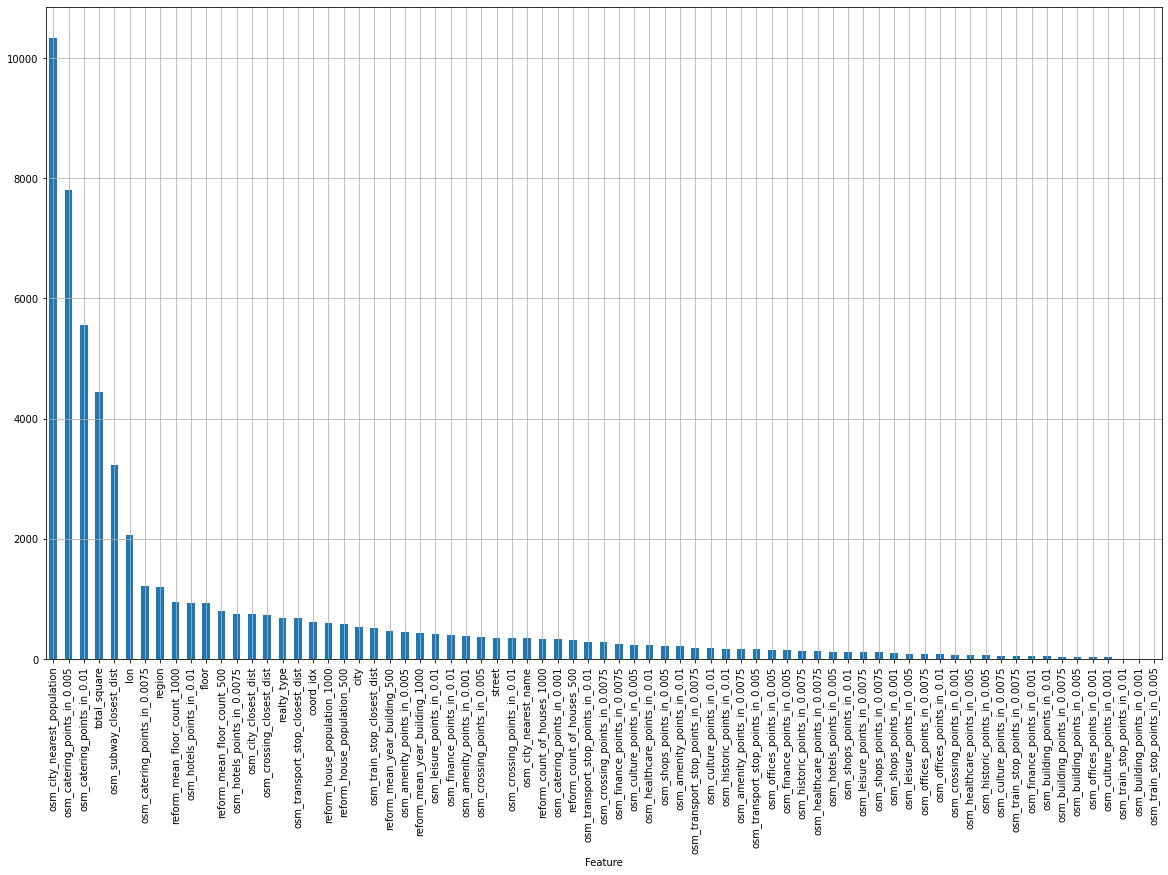

In [11]:
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize=(20, 12), grid=True)

In [12]:
prediction = automl.predict(test_data)

In [13]:
test_data[TARGET_NAME] = prediction.data[:, 0]

In [14]:
test_data[['id', TARGET_NAME]].to_csv('sample_submission.csv', index=False)